# Рынок заведений общественного питания Москвы

Описание проекта  
Мы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможем ли мы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?
Партнёры просят нас подготовить исследование рынка. У нас есть открытые данные о заведениях общественного питания в Москве.

Описание данных  
Таблица `rest_data`:  
`id` — идентификатор объекта;  
`object_name` — название объекта общественного питания;  
`chain` — сетевой ресторан;  
`object_type` — тип объекта общественного питания;  
`address` — адрес;  
`number` — количество посадочных мест.  


## Шаг №1. Загрузите данные и подготовьте их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [2]:
rest_data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [5]:
rest_data['object_name'] = rest_data['object_name'].str.lower()
rest_data['address'] = rest_data['address'].str.lower()

Проверим, какую часть составляют нулевые значения количества посадочных мест

In [6]:
rest_data.query('number==0')['number'].count()/len(rest_data)

0.10549264610178316

Проверим данные на дубликаты

In [7]:
rest_data.duplicated().sum()

0

Возможны дубликаты без учета id, проверим наличие таких дублирующих записей

In [8]:
duplicated_count = rest_data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated().sum()
duplicated_count

85

In [9]:
rest_data[rest_data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated()].head()

,id,object_name,chain,object_type,address,number
2381,28611,комбинат питания мгту им.н.э.баумана,нет,столовая,"город москва, 2-я бауманская улица, дом 5, стр...",100
3397,71896,буфет «коникс-школьник»,нет,буфет,"город москва, улица удальцова, дом 21",100
3481,20914,буфет мади,нет,буфет,"город москва, ленинградский проспект, дом 64",40
4431,23759,столовая гбоу города москвы № 384,нет,буфет,"город москва, беловежская улица, дом 67",100
4537,23391,столовая «комбинат питания космос»,нет,столовая,"город москва, новозаводская улица, дом 12/11",15


In [10]:
rest_data[rest_data['object_name']=='столовая «комбинат питания космос»']

,id,object_name,chain,object_type,address,number
4536,23381,столовая «комбинат питания космос»,нет,столовая,"город москва, новозаводская улица, дом 12/11",15
4537,23391,столовая «комбинат питания космос»,нет,столовая,"город москва, новозаводская улица, дом 12/11",15


In [11]:
duplicated_count/len(rest_data)*100

0.5531693348952232

In [12]:
rest_data = rest_data[~rest_data[['object_name', 'chain', 'object_type', 'address', 'number']].duplicated()]

Мы загрузили данные о заведениях общественного питания Москвы в датаврейм. Типы всех колонок верные, пропуски остутствуют, данные текстовых столбцов были приведены к нижнему регистру. У 10% заведений число посадочных мест равно нулю, что не является аномалией, это могут быть пункты выдачи сетевых кафе и фудкорты. Были обнаружены дубликаты - заведения с одинаковыми названиями и адресом, числом посадочных мест, но разным id. Считаем, что несколько заведений могут находиться по одному адресу(например в торговом центре). Таких значений около 0.5%, удалим их, что существенно не повлияет на результаты анализа.

## Шаг №2. Анализ данных

Исследуем соотношение видов объектов общественного питания по количеству.

In [13]:
count_type = rest_data['object_type'].value_counts().reset_index()
count_type.columns = ['object_type', 'count']

In [14]:
count_type.sort_values(by = 'count', ascending = False)

,object_type,count
0,кафе,6071
1,столовая,2584
2,ресторан,2282
3,предприятие быстрого обслуживания,1897
4,бар,855
5,буфет,576
6,кафетерий,395
7,закусочная,348
8,магазин (отдел кулинарии),273


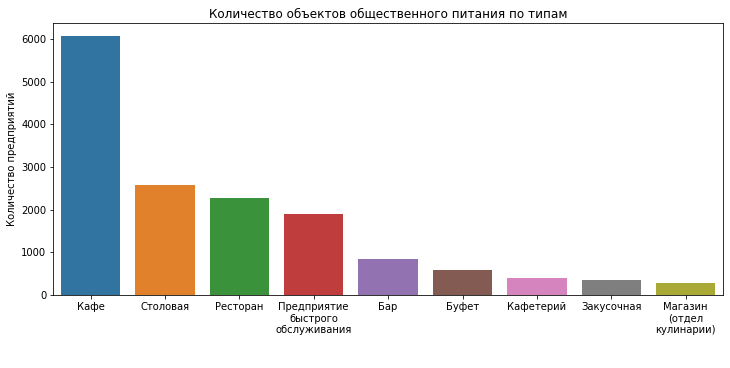

In [15]:
plt.figure(figsize=(12, 5))
sns.barplot(x = 'object_type', y = 'count', data = count_type)
plt.xticks(np.arange(9), ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания\n ', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел\nкулинарии)\n'))
plt.title('Количество объектов общественного питания по типам')
plt.ylabel('Количество предприятий')
plt.xlabel(' ')
plt.show()

Больше всего предприятий имеют тип "Кафе" - 6071 шт, приблизительно на одном уровне находятся "столовая" - 2584, "ресторан" - 2282, "предприятие быстрого обслуживания" - 1897.

Исследуем соотношение сетевых и несетевых заведений по количеству.

In [16]:
rest_data['chain'].value_counts()

нет    12317
да      2964
Name: chain, dtype: int64

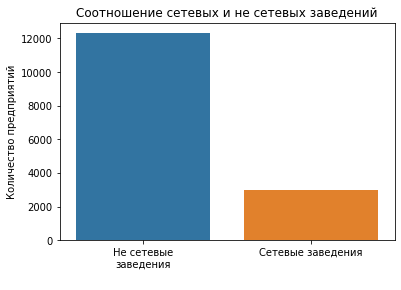

In [17]:
sns.countplot(x = 'chain', data = rest_data)
plt.xticks(np.arange(2), ('Не сетевые\nзаведения', 'Сетевые заведения'))
plt.title('Соотношение сетевых и не сетевых заведений')
plt.ylabel('Количество предприятий')
plt.xlabel(' ')
plt.show()

Сетевых заведений значительно меньше 2964 шт, чем не сетевых - 12317 шт.(около 80%)

Узнаем, для какого вида объекта общественного питания характерно сетевое распространение

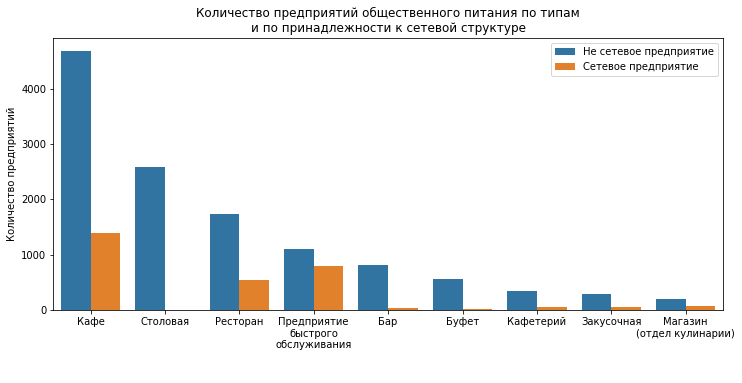

In [18]:
plt.figure(figsize=(12, 5))
sns.countplot(x='object_type', data=rest_data, hue='chain', 
                   order = rest_data['object_type'].value_counts().index) 
plt.legend(['Не сетевое предприятие', 'Сетевое предприятие'])
plt.xticks(np.arange(9), ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания\n ', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел кулинарии)'))
plt.title('Количество предприятий общественного питания по типам\nи по принадлежности к сетевой структуре')
plt.ylabel('Количество предприятий')
plt.xlabel(' ')
plt.show()

В основном сетевыми являются кафе, предприятия быстрого питания, рестораны. В остальных категориях число сетевых заведений мало.

Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [19]:
chain = rest_data[rest_data['chain']=='да']

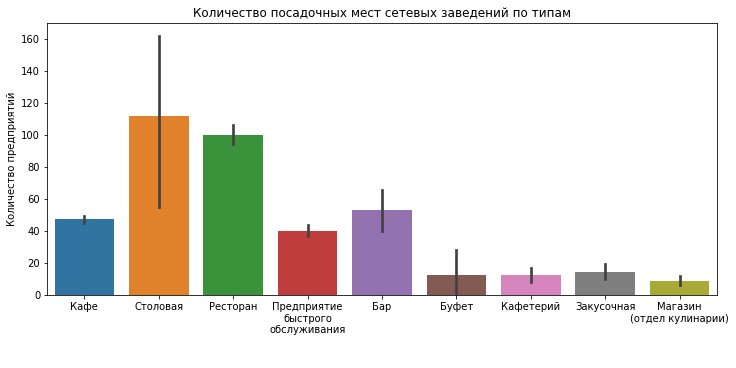

In [20]:
plt.figure(figsize=(12, 5))
sns.barplot(x='object_type', y = 'number', data=chain,
           order = rest_data['object_type'].value_counts().index) 
plt.xticks(np.arange(9), ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания\n ', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел кулинарии)'))
plt.title('Количество посадочных мест сетевых заведений по типам')
plt.ylabel('Количество предприятий')
plt.xlabel(' ')
plt.show()

In [21]:
chain['number'].describe()

count    2964.000000
mean       52.981107
std        57.152817
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64

In [22]:
chain.groupby('object_name')['id'].count().describe()

count    577.000000
mean       5.136915
std       15.526198
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max      157.000000
Name: id, dtype: float64

ТОП-3 предприятий по количеству посадочных мест - Столовая, Ресторан, Бар/Кафе. Распределение посадочных мест не нормально, лучше всего значение отражает медиана. Для сети характерно несколько заведений(75% укладывается до 3) с числом посадочных мест 40.

Выделим в отдельный столбец информацию об улице из столбца `address`

In [23]:
def street(row):
    ans = row['address'].split(',')[1]
    flag = True
    for i in ['улица','бульвар','проезд','переулок','шоссе','проспект','набережная', 'площадь', 'квартал', 'аллея']:
        if i in ans:
            flag = False
            break
    if flag:
        if 'дом' in ans or 'владение' in ans:
            ans = row['address'].split(',')[0]
        else:
            ans = row['address'].split(',')[2]
    return ans

In [24]:
rest_data['street'] = rest_data.apply(street, axis = 1)

Построим график топ-10 улиц по количеству объектов общественного питания. Посмотрим на распределение количества посадочных мест для улиц с большим количеством объектов общественного питания.

In [25]:
establ_agg = rest_data.groupby('street').agg({'id':'count',
                                              'number':'mean'}).sort_values(by = 'id',
                                                                            ascending = False).reset_index()
establ_agg.columns = ['street','count', 'number_mean']
establ_agg['number_mean'] = establ_agg['number_mean'].round(2)
establ_agg['street'] = establ_agg['street'].str.strip()

In [26]:
establ_agg.head(10)

,street,count,number_mean
0,проспект мира,203,63.00
1,профсоюзная улица,181,46.67
2,ленинградский проспект,170,52.76
3,пресненская набережная,167,45.84
4,варшавское шоссе,164,52.48
5,ленинский проспект,147,63.47
6,проспект вернадского,128,68.80
7,кутузовский проспект,114,85.06
8,каширское шоссе,111,55.50
9,кировоградская улица,108,59.79


Для определения районов, в которых находятся заведения, на данных улицах воспользуемся дополнительной информацией. Загрузим датасет мосгаз с адресами и принадлежностью к районам.

In [27]:
mosqaz_data = pd.read_csv('https://hubofdata.ru/storage/f/2013-10-22T09%3A25%3A27.793Z/mosgaz-streets.csv')

In [28]:
mosqaz_data['streetname'] = mosqaz_data['streetname'].str.lower().str.strip()
mosqaz_data = mosqaz_data[['streetname','okrug']]
mosqaz_data.head()

,streetname,okrug
0,выставочный переулок,ЦАО
1,улица гашека,ЦАО
2,большая никитская улица,ЦАО
3,глубокий переулок,ЦАО
4,большой гнездниковский переулок,ЦАО


Объединим таблицы мосгаза и аггрегирувонную таблицу по улицам, получим множество округов, через которые проходит улица, выберем самое часто встречающееся значение - моду в качестве значения округа, произведем сортировку по убыванию.

In [29]:
establ_agg = establ_agg.reset_index().merge(mosqaz_data, 
                               how = 'left',
                               left_on = 'street', 
                               right_on = 'streetname')
establ_agg = establ_agg.groupby('street').agg({'count':'min',
                        'number_mean':'min',
                         'okrug': lambda x: scipy.stats.mode(x)[0]})
establ_agg = establ_agg.sort_values(by = 'count', ascending = False)

In [30]:
establ_agg.head(10)

,count,number_mean,okrug
street,,,
проспект мира,203,63.00,СВАО
пресненская набережная,167,45.84,ЦАО
проспект вернадского,128,68.80,ЗАО
кутузовский проспект,114,85.06,ЗАО
каширское шоссе,111,55.50,ЮАО
кировоградская улица,108,59.79,ЮАО
ходынский бульвар,102,18.95,САО
ленинградское шоссе,100,44.68,САО
дмитровское шоссе,100,63.19,САО


In [31]:
establ_agg.head(10)['number_mean'].mean()

55.899

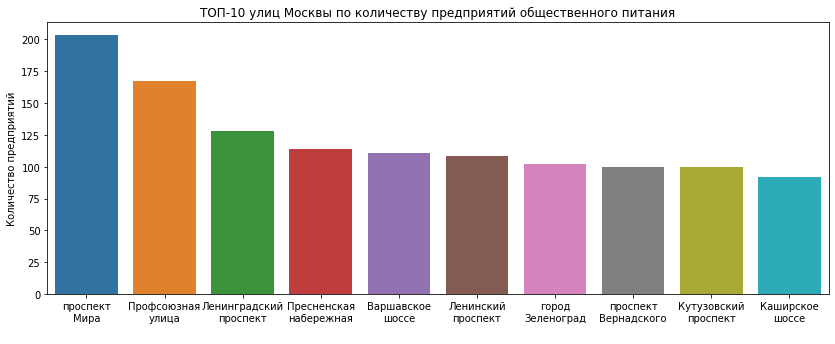

In [32]:
plt.figure(figsize=(14, 5))
sns.barplot(x='street', y = 'count', data=establ_agg.reset_index().head(10)) 
plt.xticks(np.arange(10), ('проспект\nМира', 'Профсоюзная\nулица', 'Ленинградский\nпроспект', 'Пресненская\nнабережная', 
                 'Варшавское\nшоссе', 'Ленинский\nпроспект', 'город\nЗеленоград', 'проспект\nВернадского', 
                 'Кутузовский\nпроспект', 'Каширское\nшоссе'))
plt.title('ТОП-10 улиц Москвы по количеству предприятий общественного питания')
plt.ylabel('Количество предприятий')
plt.xlabel(' ')
plt.show()

Тройка лидеров - улиц по числу предприятий общественного питания - прспект Мира, Профсоюзная улица, Ленинградский проспект.
Это большие улицы, проходящие через несколько округов города. Значения топа распределились по различным округам, 1 значение из СВАО, по 2 ЗАО, ЮАО, ЦАО, 3 значения САО. Среднее число посадочных мест в заведениях топа 10 улиц - 56 мест.

Найдем число улиц с одним объектом общественного питания.

In [33]:
establ_agg.query('count==1').count()[0]

705

In [34]:
establ_agg.query('count==1').count()[0]/len(establ_agg)

0.3384541526644263

Узнаем, в каких районах Москвы находятся эти улицы

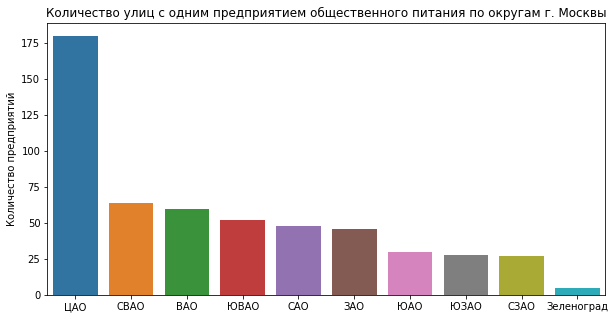

In [35]:
plt.figure(figsize=(10, 5))
sns.countplot(x='okrug', data=establ_agg.query('okrug!=0 & count==1'),
             order = establ_agg.query('okrug!=0 & count==1')['okrug'].value_counts().index)
plt.xticks(np.arange(10), ('ЦАО', 'СВАО', 'ВАО', 'ЮВАО', 'САО', 'ЗАО', 'ЮАО', 'ЮЗАО', 'СЗАО',
       'Зеленоград'))
plt.title('Количество улиц с одним предприятием общественного питания по округам г. Москвы')
plt.ylabel('Количество предприятий')
plt.xlabel(' ')
plt.show()

Около 34% улиц рассмотренного датасета имют по одному заведению общественного питания. Нибольшее число единичных предприятий находятся на улицах ЦАО.

#### Вывод
Исследовали соотношение видов объектов общественного питания по количеству. Больше всего предприятий имеют тип "Кафе" - 6071 шт, приблизительно на одном уровне находятся "столовая" - 2584, "ресторан" - 2282, "предприятие быстрого обслуживания" - 1897.
Исследовали соотношение сетевых и несетевых заведений по количеству.Сетевых заведений значительно меньше 2964 шт, чем не сетевых - 12317 шт. В основном сетевыми являются кафе, предприятия быстрого питания, рестораны. В остальных категориях число сетевых заведений мало. ТОП-3 предприятий по количеству посадочных мест - Столовая, Ресторан, Бар/Кафе. Распределение посадочных мест не нормально, лучше всего значение отражает медиана. Для сети характерно несколько заведений(75% укладывается до 3) с числом посадочных мест 40.

Тройка лидеров - улиц по числу предприятий общественного питания - прспект Мира, Профсоюзная улица, Ленинградский проспект. Это большие улицы, проходящие через несколько округов города. Значения топа распределились по различным округам, 1 значение из СВАО, по 2 ЗАО, ЮАО, ЦАО, 3 значения САО. Среднее число посадочных мест в заведениях топа 10 улиц - 56 мест. Около 34% улиц рассмотренного датасета имют по одному заведению общественного питания. Нибольшее число единичных предприятий находятся на улицах ЦАО.

## Шаг №3. Подготовка презентации

Презентация: <https://drive.google.com/file/d/1lGJxIF5cSBrAN26jK9bj9VEzQHwroqaf/view?usp=sharing> 

## Вывод

Мы загрузили данные о заведениях общественного питания Москвы в датафрейм. Типы всех колонок верные, пропуски остутствуют, данные текстовых столбцов были приведены к нижнему регистру. У 10% заведений число посадочных мест равно нулю, что не является аномалией, это могут быть пункты выдачи сетевых кафе и фудкорты. Были обнаружены дубликаты - заведения с одинаковыми названиями и адресом, числом посадочных мест, но разным id. Считаем, что несколько заведений могут находиться по одному адресу(например в торговом центре). Таких значений около 0.5%, удалили их, что существенно не повлияло на результаты анализа.

Исследовали соотношение видов объектов общественного питания по количеству. Больше всего предприятий имеют тип "Кафе" - 6071 шт, приблизительно на одном уровне находятся "столовая" - 2584, "ресторан" - 2282, "предприятие быстрого обслуживания" - 1897. Исследовали соотношение сетевых и несетевых заведений по количеству.Сетевых заведений значительно меньше 2964 шт, чем не сетевых - 12317 шт. В основном сетевыми являются кафе, предприятия быстрого питания, рестораны. В остальных категориях число сетевых заведений мало. ТОП-3 предприятий по количеству посадочных мест - Столовая, Ресторан, Бар/Кафе. Распределение посадочных мест не нормально, лучше всего значение отражает медиана. Для сети характерно несколько заведений(75% укладывается до 3) с числом посадочных мест 40.

Тройка лидеров - улиц по числу предприятий общественного питания - прспект Мира, Профсоюзная улица, Ленинградский проспект. Это большие улицы, проходящие через несколько округов города. Значения топа распределились по различным округам, 1 значение из СВАО, по 2 ЗАО, ЮАО, ЦАО, 3 значения САО. Среднее число посадочных мест в заведениях топа 10 улиц - 56 мест. Около 34% улиц рассмотренного датасета имют по одному заведению общественного питания. Нибольшее число единичных предприятий находятся на улицах ЦАО.

Формат кафе наиболее удачно подходит для концепции нашего заведения. Для единичного предприятия не сетевой структуры выбираем местоположение - Центральный Административный округ. Число посадочных мест кафе 30-40.